In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper.lattice_surgery_schedule import LatticeSurgerySchedule
from swiper.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper.device_manager import DeviceManager
from swiper.window_builder import WindowBuilder
from swiper.window_manager import SlidingWindowManager
from swiper.decoder_manager import DecoderManager
from swiper.simulator import DecodingSimulator
import swiper.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

In [3]:
scheduling_method = 'parallel'

In [4]:
dag = RegularTSchedule(1000, 0).schedule.to_dag(7)

In [5]:
next(nx.topological_generations(dag))

[0, 4]

In [6]:
d=7
decoding_time = 2*d
speculation_time = 200
speculation_accuracy = 0.7
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

merge_schedule = LatticeSurgerySchedule()
merge_schedule.idle([(0,0)], 10)
merge_schedule.idle([(0,10)], 10)
merge_schedule.merge([(0,0), (0,10)], [(0,i) for i in range(1,10)])

success, device_data, window_data, decoding_data = simulator.run(
    schedule=merge_schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
    lightweight_output=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 0it [00:00, ?it/s]

Surface code rounds: 59it [00:00, 12771.01it/s]

11 15
17 59


In [7]:
device_data.instruction_start_times

[0, 0, 10, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]

In [8]:
RegularTSchedule(2, 0).schedule.full_instructions()

[Instruction(name='INJECT_T', idx=0, patches=frozenset({(1, 0)}), duration=<Duration.D: 1>, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset(), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset()),
 Instruction(name='MERGE', idx=1, patches=frozenset({(1, 0), (0, 0)}), duration=<Duration.D: 1>, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset({3}), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset({((0, 0), (1, 0))})),
 Instruction(name='DISCARD', idx=2, patches=frozenset({(1, 0)}), duration=0, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset(), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset()),
 Instruction(name='CONDITIONAL_S', idx=3, patches=frozenset({(0, 0)}), duration=<Duration.HALF_D_PLUS_2: 3>, conditioned_on_idx=frozenset({1}), condi

In [9]:
list(RegularTSchedule(2, 0).schedule.to_dag().predecessors(5))

[3, 4]

In [10]:
simulator._device_manager._instruction_durations[3]

0

## RegularTSchedule, not using speculation

Here, speculation time is much longer than decoding time, so we are just doing
standard sliding window.

In [11]:
d=7
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [12]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [13]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0
)

Surface code rounds: 131it [00:00, 18786.03it/s]

12 21


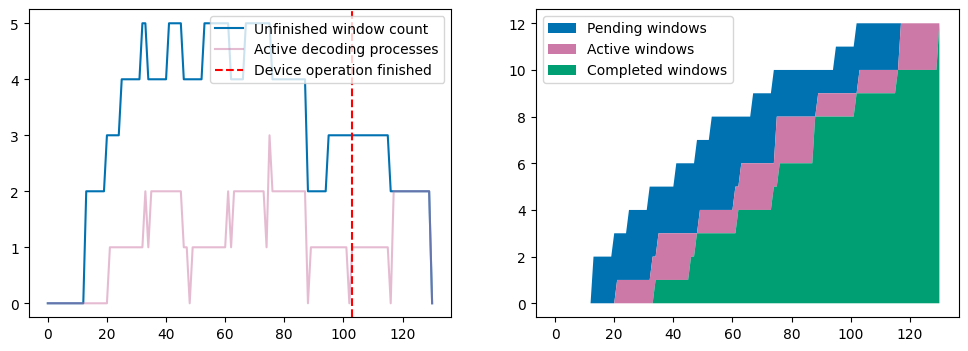

In [14]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), np.array(decoding_data.completed_windows_by_round)+np.array(decoding_data.parallel_processes_by_round), window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, np.array(decoding_data.completed_windows_by_round) + np.array(decoding_data.parallel_processes_by_round), label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe that the number of active decoding processes is far lower, but the rate
of completing windows remains the same.

<Axes3D: >

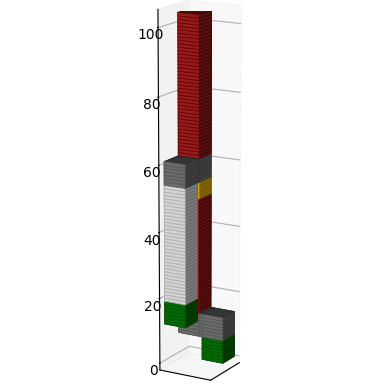

In [15]:
plotter.plot_device_schedule_trace(device_data)

<Axes3D: >

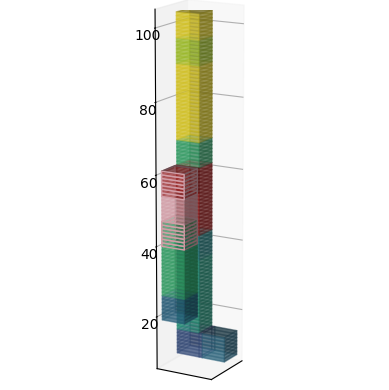

In [16]:
plotter.plot_windows(
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[7, 6],
    spacing=1,
)

## 15 - 1 Factory

In [17]:
d=15
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [18]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [19]:
success, device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
)

Surface code rounds: 277it [00:00, 3552.92it/s]

141 235


In [20]:
len(simulator._window_manager.all_windows)

239

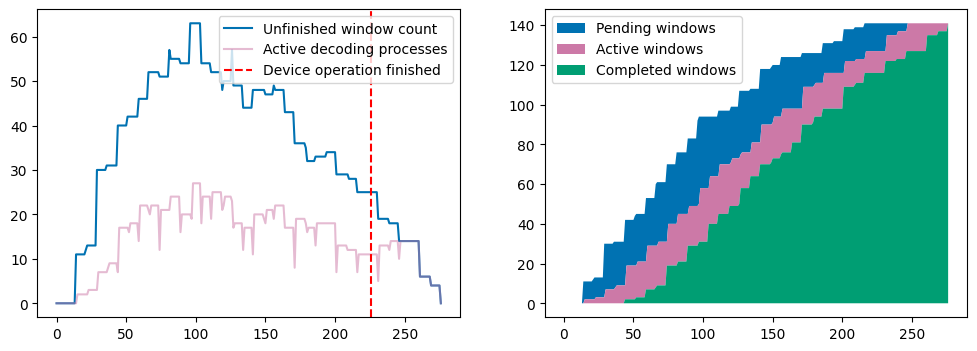

In [21]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), np.array(decoding_data.completed_windows_by_round)+np.array(decoding_data.parallel_processes_by_round), window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, np.array(decoding_data.completed_windows_by_round) + np.array(decoding_data.parallel_processes_by_round), label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Text(0.5, 0.92, 'parallel (277 rounds)')

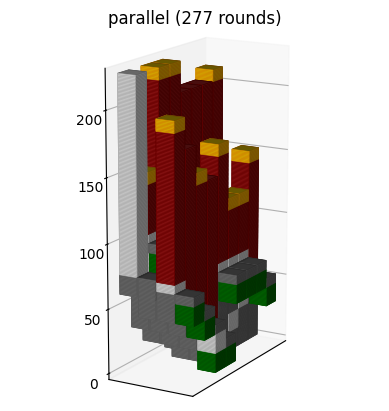

In [22]:
plotter.plot_device_schedule_trace(device_data, spacing=1)
plt.title(f'{scheduling_method} ({decoding_data.num_rounds} rounds)')

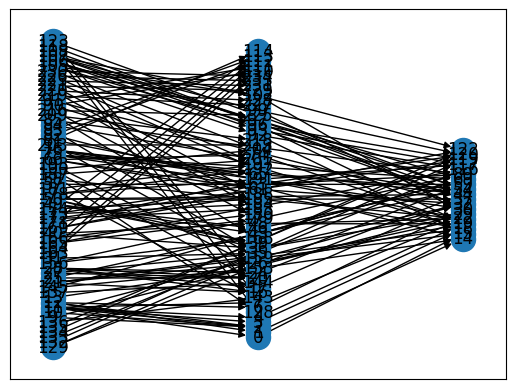

In [23]:
draw_dag(nx.DiGraph(window_data.window_dag_edges))

<Axes3D: >

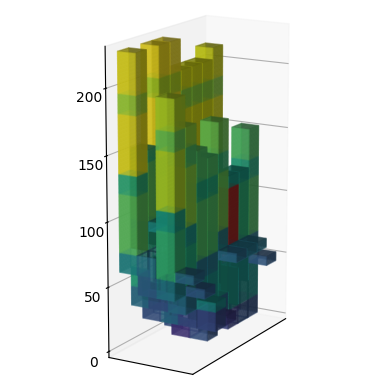

In [24]:
selected_window_idx_1 = -1
for i in window_data.all_constructed_windows:
    window = window_data.get_window(i)
    if selected_window_idx_1 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (3,3):
            selected_window_idx_1 = i
            break

selected_window_idx_2 = -1
for i in window_data.all_constructed_windows:
    window = window_data.get_window(i)
    if selected_window_idx_2 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (2,7) and cr.duration == 3:
            selected_window_idx_2 = i
            break

plotter.plot_windows(
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[selected_window_idx_1, selected_window_idx_2],
    spacing=1,
)

In [25]:
d=7
decoding_time = 14
speculation_time = 0
speculation_accuracy = 0
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(1, 0).schedule,
    scheduling_method='sliding',
    max_parallel_processes=None,
    rng=0,
)

7 7


In [26]:
window_data.all_windows

[Window((Region((1, 0), 7, 7, 3, False, True),), frozenset({Region((0, 0), 7, 7, 3, True, False)}), frozenset({1}), True),
 Window((Region((0, 0), 7, 7, 3, True, False),), frozenset({Region((0, 0), 14, 7, 4, False, False)}), frozenset({1}), True),
 Window((Region((0, 0), 14, 7, 4, False, False),), frozenset({Region((0, 0), 21, 7, 4, False, False)}), frozenset({-1}), True),
 Window((Region((0, 0), 21, 7, 4, False, False),), frozenset({Region((0, 0), 28, 7, 4, False, False)}), frozenset({-1}), True),
 Window((Region((0, 0), 28, 7, 4, False, False),), frozenset({Region((0, 0), 35, 7, 4, False, False)}), frozenset({-1}), True),
 Window((Region((0, 0), 35, 7, 4, False, False),), frozenset({Region((0, 0), 42, 5, 4, False, True)}), frozenset({-1}), True),
 Window((Region((0, 0), 42, 5, 4, False, True),), frozenset(), frozenset({3}), True)]

In [27]:
decoding_data.window_decoding_start_times

{0: 14, 1: 28, 2: 42, 3: 56, 4: 70, 5: 84, 6: 98}

In [28]:
decoding_data.window_decoding_completion_times

{0: 27, 1: 41, 2: 55, 3: 69, 4: 83, 5: 97, 6: 111}

In [29]:
device_data.instruction_start_times

[0, 7, 14, 42, 47]

In [30]:
device_data.instructions

[Instruction(name='INJECT_T', idx=0, patches=frozenset({(1, 0)}), duration=<Duration.D: 1>, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset(), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset()),
 Instruction(name='MERGE', idx=1, patches=frozenset({(1, 0), (0, 0)}), duration=<Duration.D: 1>, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset({3}), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset({((0, 0), (1, 0))})),
 Instruction(name='DISCARD', idx=2, patches=frozenset({(1, 0)}), duration=0, conditioned_on_idx=frozenset(), conditional_dependencies=frozenset(), conditioned_on_completion_idx=frozenset(), conditional_completion_dependencies=frozenset(), merge_faces=frozenset()),
 Instruction(name='CONDITIONAL_S', idx=3, patches=frozenset({(0, 0)}), duration=<Duration.HALF_D_PLUS_2: 3>, conditioned_on_idx=frozenset({1}), condi

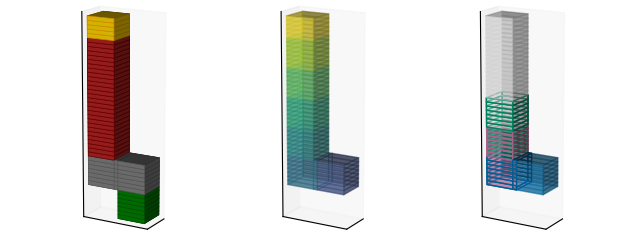

In [31]:
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1,3,1, projection='3d')
ax1 = fig.add_subplot(1,3,2, projection='3d')
ax2 = fig.add_subplot(1,3,3, projection='3d')

plotter.plot_device_schedule_trace(device_data, ax=ax0, hide_z_ticks=True)

plotter.plot_windows(
    ax=ax1,
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[],
    hide_z_ticks=True,
)

plotter.plot_windows(
    ax=ax2,
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[0,1,2],
    window_cmap=None,
    selected_window_colors=['C0', 'C1', 'C2'],
    hide_z_ticks=True,
)

ax0.set_aspect('equal')
ax1.set_zlim(ax0.get_zlim())
ax1.set_aspect('equal')
ax2.set_zlim(ax0.get_zlim())
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=-0.1)
plt.savefig('test.svg', dpi=300, bbox_inches='tight')

# Stress test

In [32]:
d=7
decoding_time = 2*d
speculation_time = 2
speculation_accuracy = 0.7

In [33]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [34]:
%%prun
success, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(1000, 0).schedule,
    scheduling_method=scheduling_method,
    max_parallel_processes=None,
    progress_bar=True,
    lightweight_output=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 46133it [00:11, 4004.29it/s]

7803 15108
46117 46133
 

         28364194 function calls (26775131 primitive calls) in 11.301 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    46118    1.597    0.000    3.354    0.000 device_manager.py:194(_update_active_instructions)
436732/139860    1.096    0.000    1.571    0.000 device_manager.py:104(_predict_instruction_start_time)
   141805    0.746    0.000    1.552    0.000 dag.py:39(descendants)
   170895    0.483    0.000    1.567    0.000 window_manager.py:227(count_covered_faces)
410513/46117    0.368    0.000    0.891    0.000 copy.py:128(deepcopy)
    46117    0.360    0.000    0.728    0.000 window_builder.py:187(build_windows)
5496543/5197323    0.291    0.000    0.345    0.000 {built-in method builtins.len}
   243231    0.208    0.000    0.426    0.000 breadth_first_search.py:19(generic_bfs_edges)
   349682    0.200    0.000    0.627    0.000 window_builder.py:162(buffer_boundary_commits)
    46133    0.189    0.000   11.417 